In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN

In [2]:
# Load data
df=pd.read_csv("D:/ChargePoint/bus-stops-data.csv")
#Test data loaded or not
#print(df.head())
#print(df.describe(include="all"))

#Convert timestamp to datetime
df["start"]=pd.to_datetime(df["start"],unit='ms',utc=True)
df["start_local"]=df["start"].dt.tz_convert('Europe/Amsterdam')
df = df.sort_values('start_local').reset_index(drop=True)
df['hour']=df["start_local"].dt.hour
df['day_name']=df["start_local"].dt.day_name()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_name']=pd.Categorical(df['day_name'],categories=days_order,ordered=True)
#print(df.head())
df.to_csv("D:/ChargePoint/stop_convert.csv")

min value:0.009,max value:72539.543,avg:25.402874912791887
56


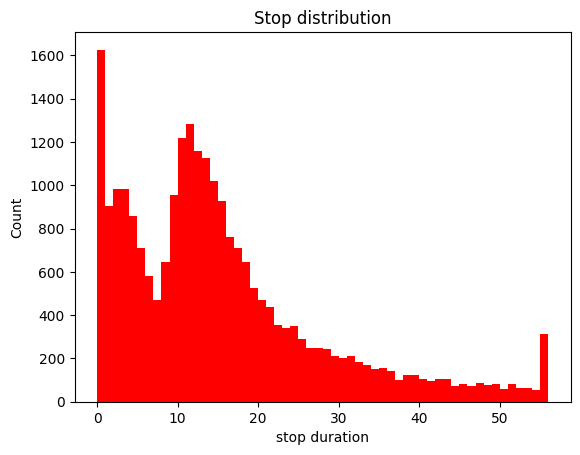

In [4]:
min_val=df['duration'].min()
max_val=df['duration'].max()
mean=df['duration'].mean()
print(f"min value:{min_val},max value:{max_val},avg:{mean}") # To check range
p99=df['duration'].quantile(.99)
bins=np.arange(0,int(p99)+1,1)
upper_lim=bins[-1]
print(upper_lim)
clipped_data=df['duration'].clip(upper=upper_lim)
plt.figure()
counts,bins,patches=plt.hist(clipped_data,bins=bins,edgecolor='none',color='r')
plt.xlabel("stop duration")
plt.ylabel("Count")
plt.title("Stop distribution")
plt.show()

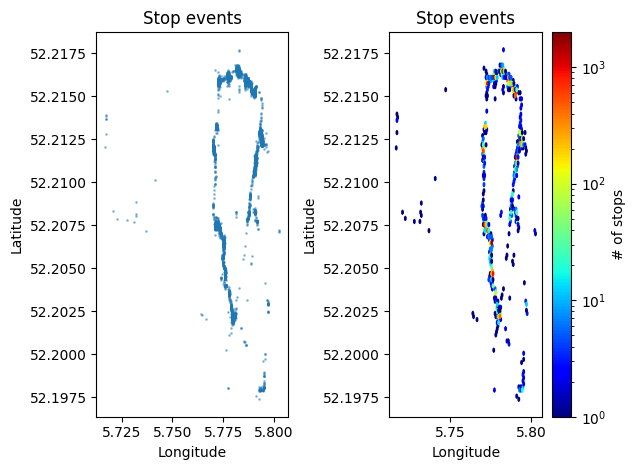

In [5]:
fig,axes=plt.subplots(nrows=1,ncols=2)
axes[0].scatter(df['lon'],df['lat'],s=1,alpha=.4)
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
axes[0].set_title("Stop events")
#axes[0].axis('equal')

hb=axes[1].hexbin(df['lon'],df['lat'],cmap='jet',mincnt=1,bins='log')
cb=fig.colorbar(hb,ax=axes[1],label="# of stops")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")
axes[1].set_title("Stop events")
plt.tight_layout()

In [6]:
#Remove very short duration <8 seconds
Min_Duration=7
df_filt=df[df['duration']>Min_Duration].copy()
print(f"Previous data points:{len(df)} Filtered data point:{len(df_filt)}")

Previous data points:24367 Filtered data point:17682


In [7]:
#Trip identification
gap_min=30
df_filt['previous']=df_filt['start'].shift(1)
df_filt['time_gap']=(df_filt['start']-df_filt['previous']).dt.total_seconds()/60
#df_filt['time_gap'].head()
df_filt['new_trip']=(df_filt['time_gap']>gap_min | df_filt['time_gap'].isna())
#df_filt['new_trip'].head()
df_filt['trip_id']=df_filt['new_trip'].cumsum()
#df_filt['trip_id'].head()
print(f"Number of trips: {df_filt['trip_id'].nunique()}")

Number of trips: 314


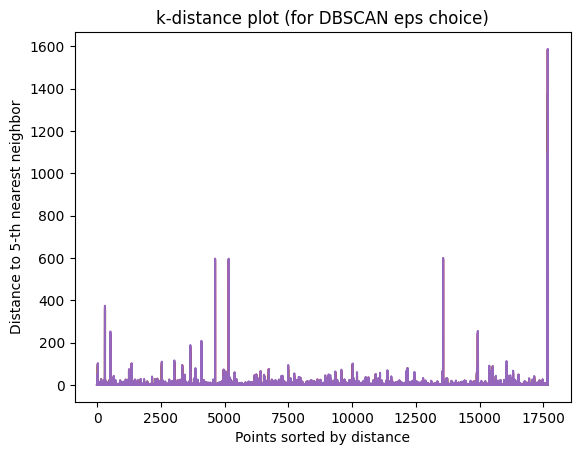

In [8]:
from sklearn.neighbors import NearestNeighbors
coords=np.radians(df_filt[['lat','lon']].values)
#coords[:5]
k=5
nbrs=NearestNeighbors(n_neighbors=k,metric='haversine').fit(coords)
distances,indices=nbrs.kneighbors(coords)
#print(distances[:5])
earth_radius=6371000
dist_mtr=np.sort(distances[:-1]*earth_radius)
#print(dist_mtr[:5])
plt.figure()
plt.plot(dist_mtr)
plt.ylabel(f"Distance to {k}-th nearest neighbor")
plt.xlabel("Points sorted by distance")
plt.title("k-distance plot (for DBSCAN eps choice)")
plt.show()

In [9]:
#The main dense region:5-40 mtrs,rise starts above 40-60 mtrs
#spike after 200 mtrs are noise and not elbow;
# bus stop cluster radius 15-25 mtrs;GPS fluctuations (5-10 mtrs)
#stop events occurs around 30-50 mtr radius
#assume eps=40 mtr
EPS=40/earth_radius
Min_Sample=20
db=DBSCAN(eps=EPS,min_samples=Min_Sample,metric='haversine')
df_filt['cluster']=db.fit_predict(coords)
#df_filt.head()
print(df_filt['cluster'].value_counts().sort_index())
#cluster -1 includes all noise points. All other clusters can be considered as physical stop.

cluster
-1      184
 0     3609
 1      700
 2     2099
 3       39
 4     1530
 5     1181
 6     1303
 7      901
 8     1496
 9     1475
 10     451
 11    1695
 12     157
 13     785
 14      48
 15      29
Name: count, dtype: int64


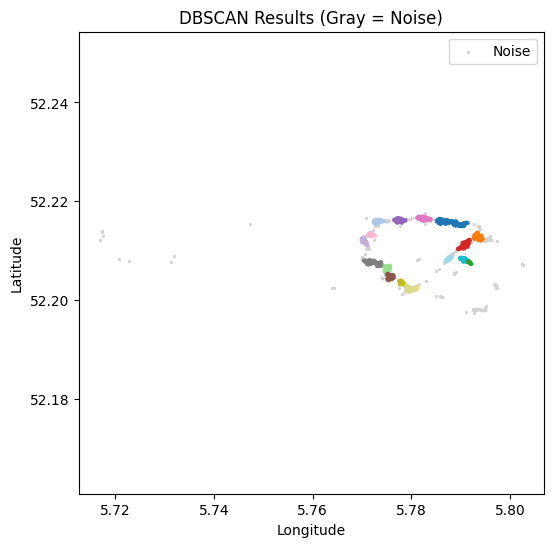

In [10]:
plt.figure(figsize=(6,6))
noise=df_filt[df_filt['cluster']==-1]
plt.scatter(noise['lon'],noise['lat'],s=2,c='lightgray',label='Noise')
valid=df_filt[df_filt['cluster']!=-1]
plt.scatter(valid['lon'],valid['lat'],s=5,c=valid['cluster'],cmap='tab20',alpha=.8)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("DBSCAN Results (Gray = Noise)")
plt.axis('equal') # Keeps the map shape correct
plt.legend()
plt.show()

In [11]:
# Define Haversine formula for comuting approx cluster distance

R = 6371000  # meters

def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c



In [12]:
#Aggregate cluster stat:
df_clusters=df_filt[df_filt['cluster']>=0].copy()
#df_clusters.head()

In [13]:
cluster_stats=df_clusters.groupby('cluster').agg(
    lat_mean=('lat','mean'),
    lat_p5=('lat',lambda x:np.percentile(x,5)),
    lat_p95=('lat',lambda x:np.percentile(x,95)),
    lon_mean=('lon','mean'),
    lon_p5=('lon',lambda x:np.percentile(x,5)),
    lon_p95=('lon',lambda x:np.percentile(x,95)),

    #n_events=('cluster','size'),
    #n_trips=('trip_id','nunique'),

    duration_mean=('duration','mean'),
    duration_std=('duration','std'),
    #duration_max=('duration', 'max'),
    #duration_min=('duration', 'min'),
    
).reset_index()
#cluster_stats
cluster_stats['dist_mtr']=haversine(cluster_stats['lat_p5'],cluster_stats['lon_p95'],
    cluster_stats['lat_p95'], cluster_stats['lon_p95']
)
cluster_stats['Duration_CV']=cluster_stats['duration_std']/cluster_stats['duration_mean']
#cluster_stats
cluster_stats['type']='unknown'
conditions=[(cluster_stats['dist_mtr']<50),
           ((cluster_stats['dist_mtr']>=50) & (cluster_stats['dist_mtr']<100)),
           ]
choices=['Busstop','Terminus']
cluster_stats['type']=np.select(conditions,choices,default='Traffic')
cluster_stats.head()


,cluster,lat_mean,lat_p5,lat_p95,lon_mean,lon_p5,lon_p95,duration_mean,duration_std,dist_mtr,Duration_CV,type
0,0,52.215643,52.215121,52.216029,5.787912,5.785600,5.790391,25.144343,15.293256,100.953874,0.608219,Traffic
1,1,52.215814,52.215735,52.215930,5.772833,5.772595,5.773399,22.579790,12.567449,21.632973,0.556580,Busstop
2,2,52.212554,52.212241,52.212989,5.793577,5.793244,5.793875,23.605531,52.379481,83.138223,2.218949,Terminus
3,3,52.207709,52.207507,52.207774,5.791583,5.791506,5.791827,29.777462,17.962805,29.692159,0.603235,Busstop
4,4,52.206501,52.206405,52.206572,5.775220,5.775097,5.775304,20.343887,11.365870,18.664068,0.558687,Busstop


In [14]:
summary_table=cluster_stats['type'].value_counts()
summary_table.columns=['Category','Count']
summary_table

type
Busstop     11
Terminus     4
Traffic      1
Name: count, dtype: int64